The main point of this notebook is to (1) check out the TESS data of this system and make sure it's clean for use in my light curve fitting and (2) shorten the data, so that I don't have an unuseful amount of out-of-transit data points that will primarily slow down my fit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
from astropy.io import fits

import warnings
warnings.filterwarnings('ignore')

In [2]:
#####################
# Load in TESS data
dvtfile = '/home/mmmurphy/data/hd219666b/tess_data/tess2018206190142-s0001-s0001-0000000266980320-00366_dvt.fits'
with fits.open(dvtfile, mode='readonly') as hdu:
    # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
    # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
    # model fluxes.
    times = hdu[1].data['TIME']
    phase = hdu[1].data['PHASE']
    flux = hdu[1].data['LC_INIT']
    model = hdu[1].data['MODEL_INIT']
    
Ndata_initial = len(times)
    
# some input tess flux values are nan
badidx = np.where(np.isnan(flux))
Nbad = len(badidx)

times = np.delete(times, badidx) 
times += + 2457000.0
phase = np.delete(phase, badidx)
flux = np.delete(flux, badidx)
model = np.delete(model, badidx)

# the flux data is set about 0
# setting it about 1
flux += 1.

# the data does not come with an associated uncertainty
# so i'll use the residual between the data and the given model
#    as the uncertainty
residuals = flux - model
uncy = np.asarray([np.std(residuals)]*len(times))

# t_bjdtdb_TESS = times_tess + 2457000.0

# resids_init_tess = fluxes_init_tess - model_fluxes_init_tess
# err_TESS = np.asarray([np.std(resids_init_tess)]*len(t_bjdtdb_TESS))

# flux_TESS = fluxes_init_tess + 1.

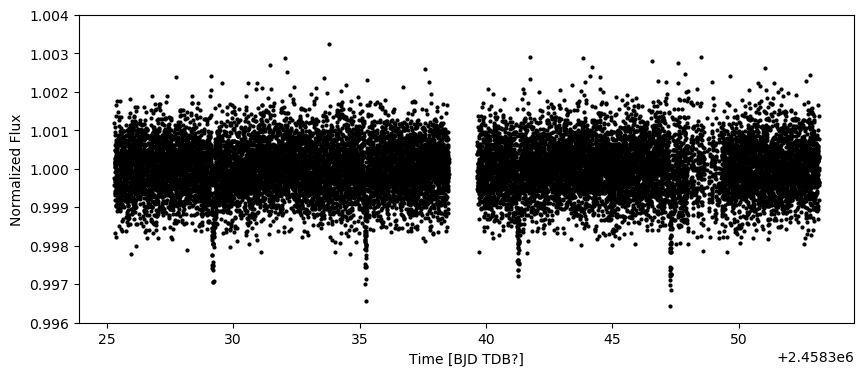

In [3]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(times, flux, c='black', s=4)
ax.set_xlabel('Time [BJD TDB?]')
ax.set_ylabel('Normalized Flux')
ax.set_ylim(0.996, 1.004)
plt.show()

I want to cut out the majority of these out-of-transit points. I'll cut everything outside of +/- 2 hours of a transit

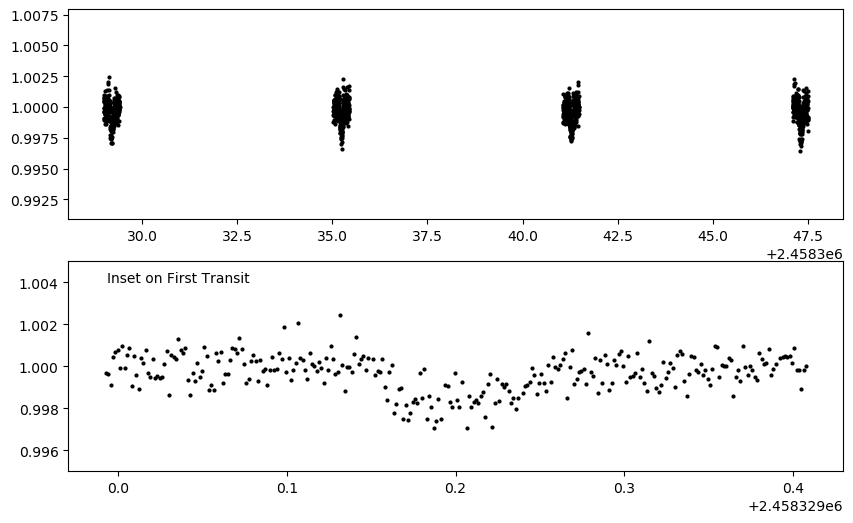

In [4]:
lit_tc = 2458329.1996  # [day; bjd tdb]
lit_P = 6.034460       # [day]

t0 = lit_tc
t1 = t0 + lit_P
t2 = t1 + lit_P
t3 = t2 + lit_P

halfwindow = 5. / 24.  # [hour] / [hour per day] = [day]; amount of time to keep on either side of transit 
w0idx = np.where((times >= t0-halfwindow)&(times <= t0+halfwindow))[0]
w1idx = np.where((times >= t1-halfwindow)&(times <= t1+halfwindow))[0]
w2idx = np.where((times >= t2-halfwindow)&(times <= t2+halfwindow))[0]
w3idx = np.where((times >= t3-halfwindow)&(times <= t3+halfwindow))[0]

tessuseidx = np.concatenate((w0idx, w1idx, w2idx, w3idx))

t_short = times[tessuseidx]
f_short = flux[tessuseidx]
u_short = uncy[tessuseidx]


fig, ax = plt.subplots(figsize=(10, 6), nrows=2)
ax[0].scatter(times[tessuseidx], flux[tessuseidx], c='black', s=4)
ax[1].scatter(times[w0idx], flux[w0idx], c='black', s=4)
ax[1].text(0.05, 0.9, 'Inset on First Transit', transform=ax[1].transAxes)
ax[1].set_ylim(0.995, 1.005)
plt.show()

In [7]:
Ndata_end = len(tessuseidx)

print('Number of data points at start = %d'%(Ndata_initial))
print('Number of data points removed b/c nan = %d'%(Nbad))
print('Number of data points removed b/c brevity = %d'%(Ndata_initial-Ndata_end))
print('Number of data points remaining for analysis = %d'%(Ndata_end))

Number of data points at start = 20076
Number of data points removed b/c nan = 1
Number of data points removed b/c brevity = 18930
Number of data points remaining for analysis = 1146


In [5]:
saveData=True
if saveData:
    path = '/home/mmmurphy/data/hd219666b/reduced_data/'
    np.savez(path+'shortened_TESS_lightcurve.npz', times=t_short, fluxes=f_short, errs=u_short)
    print('Data saved to ', path)

Data saved to  /home/mmmurphy/data/hd219666b/reduced_data/


In [6]:
# save_data = True
# if save_data:

#     filename = '/home/mmmurphy/data/hd219666b/reduced_data/shortened_TESS_lightcurve.dat'
#     file = open(filename, 'w')
#     file.write('# Shortened TESS light curves of HD 219666b \n')
#     file.write('# Time [BJD TDB; From TESS DVT], Normalized Flux, Normalized Flux Uncertainty \n')
#     for i, time in enumerate(t_short):
#         file.write(str(t_short[i]))
#         file.write(' ')
#         file.write(str(f_short[i]))
#         file.write(' ')
#         file.write(str(u_short[i]))
#         file.write('\n')
    
#     file.close()